# Feature-based clustering of time-series data

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)

from sktime.transformations.panel.catch22 import Catch22
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [2]:
def generate_sample(
        df_ts: pd.DataFrame,
        df_label: pd.DataFrame,
        n: int=1872
    ) -> pd.DataFrame:
    #df_ts = pd.read_csv("df_clean.csv")
    df_ts["date"] = pd.to_datetime(df_ts["date"])

    if "Unnamed: 0" in df_ts.columns:
        df_ts.drop(columns=['Unnamed: 0'], inplace=True)

    np.random.seed(11) # set random seed for reproducibility

    uuid_list = df_ts["uuid"].unique().tolist()
    uuid_random = np.random.choice(uuid_list, n, replace=False)

    # Random subset consisting of 500 uuid samples
    df_random = df_ts[df_ts["uuid"].isin(uuid_random)]

    df_transformed = df_random.set_index(["uuid", "date"])[["ndvi"]]

    return df_transformed

In [3]:
df_ts = pd.read_csv("df_clean.csv")
df_ts["date"] = pd.to_datetime(df_ts["date"])
df_label = pd.read_csv("/Users/rafidmahbub/Desktop/DataKind_Geospatial/crop_classification/time_series_analyses/ndvi_series_labeled/Trans_Nzoia_1_tile_0_NDVI_labels.csv")

missing_list = list(set(df_ts["uuid"]) - set(df_label["uuid"]))
df_ts = df_ts[~df_ts["uuid"].isin(missing_list)]

if "Unnamed: 0" in df_ts.columns:
    df_ts.drop(columns=['Unnamed: 0'], inplace=True)

if "Unnamed: 0" in df_label.columns:
    df_label.drop(columns=['Unnamed: 0'], inplace=True)

df_transformed = df_ts.set_index(["uuid", "date"])[["ndvi"]]

In [4]:
df_transformed

ndvi
uuid                                 date                
000f5041-32c0-4a8a-b139-83bf4845d9e6 2020-01-02  0.655667
                                     2020-01-07  0.661512
                                     2020-01-12  0.667357
                                     2020-01-17  0.605786
                                     2020-01-22  0.506952
...                                                   ...
ffe88305-d0d2-446f-9674-60ea1fd8be85 2024-12-06  0.571762
                                     2024-12-11  0.563071
                                     2024-12-16  0.537786
                                     2024-12-21  0.513845
                                     2024-12-26  0.489905

[682550 rows x 1 columns]

In [12]:
from sktime.datatypes import check_is_scitype

check_is_scitype(df_transformed, scitype="Panel", return_metadata=True)

(True,
 '',
 {'is_univariate': True,
  'is_empty': False,
  'has_nans': False,
  'n_features': 1,
  'feature_names': ['ndvi'],
  'dtypekind_dfip': [<DtypeKind.FLOAT: 2>],
  'feature_kind': [<DtypeKind.FLOAT: 2>],
  'n_instances': 1870,
  'is_one_series': False,
  'is_equal_length': True,
  'is_equally_spaced': True,
  'n_panels': 1,
  'is_one_panel': True,
  'mtype': 'pd-multiindex',
  'scitype': 'Panel'})

In [21]:
def timeseries_features(df: pd.DataFrame, scaler: TransformerMixin) -> pd.DataFrame:
    """ 
    This function extracts time-series features by using Catch22 on the dataframe
    by scaling the data using a given transformer.
    """
    
    ts_features = Catch22(catch24=True).fit_transform(df)
    ts_features_scaled = pd.DataFrame(scaler().fit_transform(ts_features))
    nan_cols = ts_features_scaled.columns[(ts_features.isna()).any()]
    ts_features_scaled = ts_features_scaled.drop(columns=nan_cols)

    return ts_features_scaled

### PCA

PCA is not able to identify clusters for any data scaling. For the `RobustScaler` there is evidence of two clusters. The poor performance of PCA suggest that the data exhibits nonlinearities.

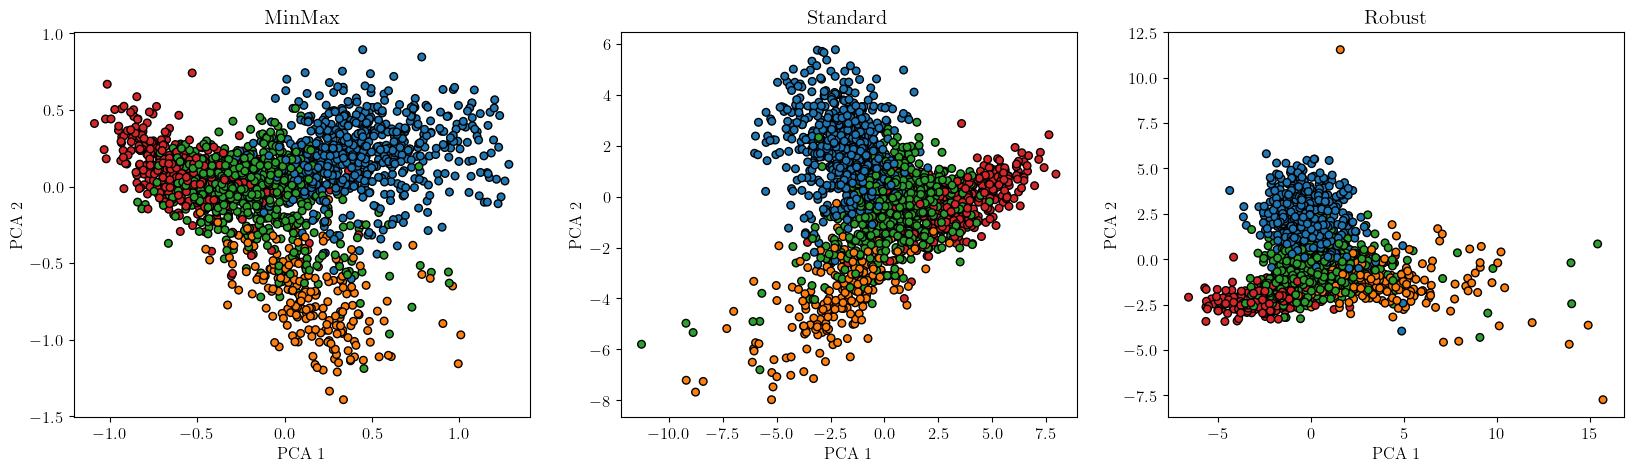

In [34]:
scalers_labels = ["MinMax", "Standard", "Robust"]
scalers = [MinMaxScaler, StandardScaler, RobustScaler]

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, scaler in enumerate(scalers):
    pca = PCA(n_components=2)

    ts_features = timeseries_features(df_transformed, scaler)
    X = pca.fit_transform(ts_features)

    # X_df = pd.DataFrame(X, columns=["PCA_1", "PCA_2"])
    # X_df["class"] = df_label["class"].tolist()

    unique_labels = df_label["class"].unique().tolist()
    palette = sns.color_palette("tab10", len(unique_labels))  # or use your own list of colors
    color_map = dict(zip(unique_labels, palette))
    colors = [color_map[cat] for cat in df_label["class"].tolist()]

    ax[i].scatter(X[:, 0], X[:, 1], s=30, c=colors, edgecolor="k")
    ax[i].set_xlabel("PCA 1", fontsize=12)
    ax[i].set_ylabel("PCA 2", fontsize=12)
    ax[i].set_title(scalers_labels[i], fontsize=15)
plt.show()

### UMAP

UMAP succeeds at isolating clusters, which PCA does not. This probably hints at the fact the data is nonlinear or resides on some kind of curved manifold. 

In [35]:
# Append scaled ts_features df in a list
df_list = [timeseries_features(df_transformed, scaler) for scaler in scalers]
df_dict = dict(zip(scalers_labels, df_list))

# Viz. Dashboards

In [47]:
from umap import UMAP
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture

df = df_dict["Standard"]
X = UMAP(
    n_components=3, 
    n_neighbors=20, 
    #densmap=True,
    random_state=15).fit_transform(df)

In [48]:
X_umap_df = pd.DataFrame(X, columns=["UMAP_1", "UMAP_2", "UMAP_3"])
X_umap_df["class"] = df_label["class"].tolist()

In [49]:
fig = px.scatter_3d(
    X_umap_df,
    x="UMAP_1",
    y="UMAP_2",
    z="UMAP_3",
    color="class",
    width=800, height=600
)
fig.update_traces(marker=dict(size=5, line=dict(width=1, color='black')))
fig.show()